In [1]:
!pip install datasets
!pip install torch
!pip install -qq transformers tokenizers accelerate sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import string
import re
import numpy as np
import torch

from datasets import load_dataset
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from scipy.spatial.distance import cosine

from tqdm.auto import tqdm
tqdm.pandas()

In [3]:
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Data Vizualization

In [4]:
df_train = pd.DataFrame({"text": dataset["train"]["text"], "label": dataset["train"]["label"]})
df_test = pd.DataFrame({"text": dataset["test"]["text"], "label": dataset["test"]["label"]})
df_train

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [5]:
for review in df_train["text"].iloc[:10]:
  print(review, '\n')

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

<Axes: title={'center': 'Test label distribution'}>

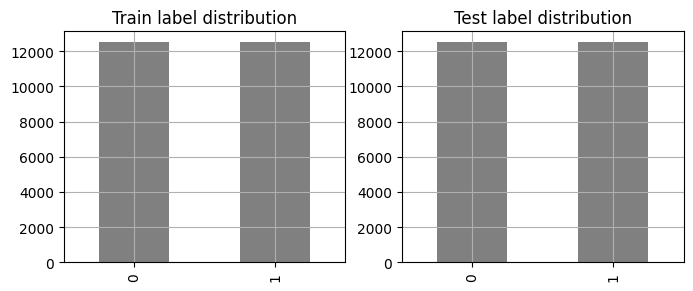

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
df_train["label"].value_counts().plot(kind='bar', grid=True, color="gray", ax=ax1, title="Train label distribution")
df_test["label"].value_counts().plot(kind='bar', grid=True, color="gray", ax=ax2, title="Test label distribution")

## Data Cleaning

In [7]:
def clean_text(review):

  review = review.lower() # lowercase
  review = re.sub(r'https?://\S+|www\.\S+', '', review) # remove links
  review = review.replace("<br /><br />", " ") # remove line break elements
  review = review.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
  review = re.sub(r'\d+', '', review) # remove digits
  review = re.sub(r' +', ' ', review) # remove extra whitespace

  printable = set(string.printable)
  review = ''.join(filter(lambda x: x in printable, review)) # remove nonascii characters

  return review

In [8]:
for review in df_train["text"].iloc[:10]:
  review = clean_text(review)
  print(review, '\n')

i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in i also heard that at first it was seized by us customs if it ever tried to enter this country therefore being a fan of films considered controversial i really had to see this for myself the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states in between asking politicians and ordinary denizens of stockholm about their opinions on politics she has sex with her drama teacher classmates and married men what kills me about i am curiousyellow is that years ago this was considered pornographic really the sex and nudity scenes are few and far between even then its not shot like some cheaply made porno 

In [9]:
df_train["text_cleaned"] = df_train["text"].apply(lambda x: clean_text(x))
df_test["text_cleaned"] = df_test["text"].apply(lambda x: clean_text(x))

In [10]:
df_train.duplicated().sum()

96

## Embeddings and cosine distance

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
minilm_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

In [12]:
print("Distance between review of one category: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text"].iloc[1]),
    minilm_model.encode(df_train["text"].iloc[2])))
)
print("Distance between review of different categories: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text"].iloc[-1]),
    minilm_model.encode(df_train["text"].iloc[1]))), '\n'
    )

print("Distance between review (cleaned) of one category: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text_cleaned"].iloc[1]),
    minilm_model.encode(df_train["text_cleaned"].iloc[2])))
)
print("Distance between review (cleaned) of different categories: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text_cleaned"].iloc[-1]),
    minilm_model.encode(df_train["text_cleaned"].iloc[1])))
)

Distance between review of one category: 0.726
Distance between review of different categories: 0.928 

Distance between review (cleaned) of one category: 0.680
Distance between review (cleaned) of different categories: 0.869


In [13]:
# just curious how text cleaning affects cosine distance

def cosine_diff(idx_i, idx_j, ax, title, num_sample=500):

  idx_i_loc = df_train.iloc[np.random.choice(idx_i, num_sample)].copy()
  idx_j_loc = df_train.iloc[np.random.choice(idx_j, num_sample)].copy()

  idx_i_loc["text_emb"] = idx_i_loc["text"].progress_apply(lambda x:  minilm_model.encode(x))
  idx_j_loc["text_emb"] = idx_j_loc["text"].progress_apply(lambda x:  minilm_model.encode(x))

  idx_i_loc["text_cleaned_emb"] = idx_i_loc["text_cleaned"].progress_apply(lambda x:  minilm_model.encode(x))
  idx_j_loc["text_cleaned_emb"] = idx_j_loc["text_cleaned"].progress_apply(lambda x:  minilm_model.encode(x))

  emb_cosine = np.array(list(map(
    lambda x: cosine(x[0], x[1]),
    zip(idx_i_loc["text_emb"].to_list(),  idx_j_loc["text_emb"].to_list())
    )))

  emb_cleaned_cosine = np.array(list(map(
    lambda x: cosine(x[0], x[1]),
    zip(idx_i_loc["text_cleaned_emb"].to_list(),  idx_j_loc["text_cleaned_emb"].to_list())
    )))

  diff = emb_cleaned_cosine - emb_cosine
  ax.hist(diff, bins=50, color="gray")
  ax.set_title(title)
  ax.set_xlabel("cosine_cleaned - cosine")
  ax.text(.80, .90, diff.mean().round(3), transform=ax.transAxes)
  ax.grid()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

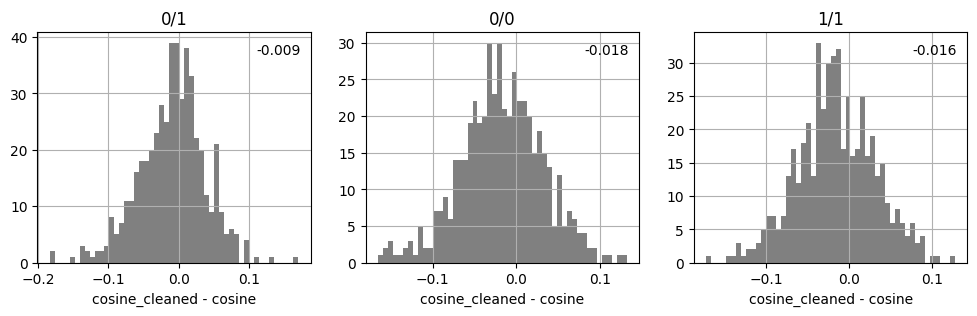

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))
neg_ids = df_train[df_train["label"] == 0].index
pos_ids = df_train[df_train["label"] == 1].index

cosine_diff(neg_ids, pos_ids, num_sample=500, title="0/1", ax=ax1)
cosine_diff(neg_ids, neg_ids, num_sample=500, title="0/0", ax=ax2)
cosine_diff(pos_ids, pos_ids, num_sample=500, title="1/1", ax=ax3)

## The most similar negative reviews

In [15]:
pos_loc = df_train.iloc[np.random.choice(neg_ids, 500, replace=False)].copy()
pos_loc["text_cleaned_emb"] = pos_loc["text_cleaned"].progress_apply(lambda x: minilm_model.encode(x))

cosine_matrix = pos_loc["text_cleaned_emb"].progress_apply(
    lambda i: pos_loc["text_cleaned_emb"].apply(lambda j: cosine(i, j))
    )

np.fill_diagonal(cosine_matrix.to_numpy(), np.inf)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
i_idx = cosine_matrix.min().sort_values().idxmin()
j_idx = cosine_matrix[i_idx].sort_values().index[0]

print("Min cosine value: {:.3f}".format(cosine_matrix.loc[i_idx, j_idx]), "\n")
print(f"Review {i_idx}:", pos_loc.loc[[i_idx, j_idx]]["text"].iloc[0])
print(f"Review {j_idx}:", pos_loc.loc[[i_idx, j_idx]]["text"].iloc[1])

Min cosine value: 0.249 

Review 5189: I feel it is my duty as a lover of horror films to warm other people about this horrible and very very bad "horror" film. Don't waste your time or money on this film, the acting is bad, the story is just one of the worst i have come across and the script was just awful. Nothing about it was good, you end up thinking to yourself why am i watching this crap. The plot had so many holes in it and they never got cleared up in the end, it was just so bad, i don't know how a film so terrible could be made. As i said before i love horror films and i was so let down, it was an 18 but you see little blood and no scares or jumps at all. Also what annoyed me was how stupid things happened in the film that had no point to the plot at all like the brother and sister kissing, why? is all i can say. Just don't bother, there are far more great horror films out there, just don't waste your time life is too short.
Review 3686: This has got to be the worst horror mov

# Binary classification with sentence transformer fine-tuning


## Get model via HF

In [17]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
train_model = AutoModelForSequenceClassification.from_pretrained('sentence-transformers/all-MiniLM-L6-v2',
                                                                 num_labels = 2)    # Download model and configuration from S3 and cache.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize text

In [18]:
def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 128,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                    )

### Train data

In [19]:
train_token_id = []
train_attention_masks = []

for sample in df_train['text_cleaned']:
  encoding_dict = preprocessing(sample, tokenizer)
  train_token_id.append(encoding_dict['input_ids'])
  train_attention_masks.append(encoding_dict['attention_mask'])


train_token_id = torch.cat(train_token_id, dim = 0)
train_attention_masks = torch.cat(train_attention_masks, dim = 0)
train_labels = torch.tensor(df_train['label'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Test data

In [20]:
test_token_id = []
test_attention_masks = []

for sample in df_test['text_cleaned']:
  encoding_dict = preprocessing(sample, tokenizer)
  test_token_id.append(encoding_dict['input_ids'])
  test_attention_masks.append(encoding_dict['attention_mask'])


test_token_id = torch.cat(test_token_id, dim = 0)
test_attention_masks = torch.cat(test_attention_masks, dim = 0)
test_labels = torch.tensor(df_test['label'])

## Create dataloaders

In [21]:
batch_size = 16

# Train and validation sets
train_set = TensorDataset(train_token_id,
                          train_attention_masks,
                          train_labels)

val_set = TensorDataset(test_token_id,
                        test_attention_masks,
                        test_labels)

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

## Add optimizer

In [22]:
optimizer = torch.optim.AdamW(train_model.parameters(),
                              lr = 5e-5,
                              eps = 1e-08
                              )

#Run on GPU
train_model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, e

## Metrics

In [23]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'

  return b_accuracy, b_precision, b_recall, b_specificity

## Training and evaluation

In [24]:
from tqdm import trange
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):

  # ========== Training ==========

    # Set model to training mode
    train_model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = train_model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask,
                              labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    train_model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = train_model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  50%|█████     | 1/2 [02:07<02:07, 127.39s/it]


	 - Train loss: 0.3604
	 - Validation Accuracy: 0.8751
	 - Validation Precision: 0.5220
	 - Validation Recall: 0.9009
	 - Validation Specificity: 0.8493



Epoch: 100%|██████████| 2/2 [04:15<00:00, 127.50s/it]


	 - Train loss: 0.2314
	 - Validation Accuracy: 0.8768
	 - Validation Precision: 0.5323
	 - Validation Recall: 0.8855
	 - Validation Specificity: 0.8680



### Evaluate the cosine distances with new fine-tuned embeddings from the model

In [25]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[1][-1] #Last hidden layer of model_output contains all token embeddings

    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [26]:
# Sentences we want sentence embeddings for
sentences = [df_train["text_cleaned"].iloc[1], df_train["text_cleaned"].iloc[2], df_train["text_cleaned"].iloc[-1]]

#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = train_model(**encoded_input.to(device),output_hidden_states=True)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1).cpu()

In [27]:
print("Distance between review (pre-trained model) of one category: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text_cleaned"].iloc[1]),
    minilm_model.encode(df_train["text_cleaned"].iloc[2])))
)
print("Distance between review (pre-trained model) of different categories: {:.3f}".format(cosine(
    minilm_model.encode(df_train["text_cleaned"].iloc[-1]),
    minilm_model.encode(df_train["text_cleaned"].iloc[1]))), '\n'
    )

print("Distance between review (new model) of one category: {:.3f}".format(cosine(
    sentence_embeddings[0],
    sentence_embeddings[1]))
)
print("Distance between review (new model) of different categories: {:.3f}".format(cosine(
    sentence_embeddings[2],
    sentence_embeddings[0]))
)

Distance between review (pre-trained model) of one category: 0.680
Distance between review (pre-trained model) of different categories: 0.869 

Distance between review (new model) of one category: 0.070
Distance between review (new model) of different categories: 1.812


### The distance increased for different categories and decreased for same category, which is **good**

# Upload to HF Hub and then to HF Spaces

In [28]:
train_model.save_pretrained("all-Mini-finetuned-imdb", from_pt=True)

In [29]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [31]:
tokenizer.push_to_hub('devashish2002/all-Mini-finetuned-imdb')
train_model.push_to_hub('devashish2002/all-Mini-finetuned-imdb')

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/devashish2002/all-Mini-finetuned-imdb/commit/2bb97a337bdcae4f8bc9a34beaa590fdaec196bf', commit_message='Upload BertForSequenceClassification', commit_description='', oid='2bb97a337bdcae4f8bc9a34beaa590fdaec196bf', pr_url=None, pr_revision=None, pr_num=None)